In [1]:
import random
import matplotlib.pyplot as plt
import torch
import time
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import os
import numpy as np
from segmentation_models_pytorch import Unet
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
id_to_label = {0: 'Basophil', 1: 'Eosinophil', 2: 'Lymphocyte', 3: 'Monocyte', 4: 'Neutrophil'}
label_to_id = {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        self.images.append(os.path.join(root_dir, subdir, filename))
                        self.targets.append(label_to_id[subdir])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = label_to_id[os.path.basename(os.path.dirname(image_path))]
        return image, label

In [3]:
def init(porportion, resize):    
    WBC_1_train_dir = 'WBC_1/train/data'
    WBC_1_train_mask_dir = 'WBC_1/train/mask'
    WBC_1_train_pred_mask_dir = 'WBC_1/train/pred_mask'
    WBC_10_train_dir = 'WBC_10/train/data'
    WBC_10_train_mask_dir = 'WBC_10/train/mask'
    WBC_10_train_pred_mask_dir = 'WBC_10/train/pred_mask'
    WBC_50_train_dir = 'WBC_50/train/data'
    WBC_50_train_mask_dir = 'WBC_50/train/mask'
    WBC_50_train_pred_mask_dir = 'WBC_50/train/pred_mask'
    WBC_100_train_dir = 'WBC_100/train/data'
    WBC_100_train_mask_dir = 'WBC_100/train/mask'
    WBC_100_train_pred_mask_dir = 'WBC_100/train/pred_mask'
    WBC_100_val_dir = 'WBC_100/val/data'
    WBC_100_mask_dir = 'WBC_100/val/mask'
    CAM16_100_train_dir = 'CAM16_100cls_10mask/train/data'
    CAM16_100_train_mask_dir = 'CAM16_100cls_10mask/train/mask'
    CAM16_100_val_dir = 'CAM16_100cls_10mask/val/data'
    CAM16_100_test_dir = 'CAM16_100cls_10mask/test/data'


    WBC_train_dir = 'WBC_' + str(proportion) + '/train/data'
    WBC_mask_dir = 'WBC_' + str(proportion) + '/train/mask'
    WBC_pred_mask_dir ='WBC_' + str(proportion) + '/train/pred_mask'

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(resize),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = CustomDataset(root_dir=WBC_train_dir, transform=train_transform)
    val_dataset = CustomDataset(root_dir=WBC_100_val_dir, transform=val_transform)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # if device == torch.device("cuda"):
    #     train_dataset = [(x.to(device), torch.tensor([y]).to(device)) for x, y in train_dataset]
    #     val_dataset = [(x.to(device), torch.tensor([y]).to(device)) for x, y in val_dataset]

    batch_size = 32
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_label_counts = Counter(train_dataset.targets)
    val_label_counts = Counter(val_dataset.targets)
    
    return train_dataloader, val_dataloader, train_label_counts, val_label_counts, device

In [4]:
def train(train_dataloader, val_dataloader, train_label_counts, val_label_counts,
          classifier_model_load_path, classifier_model_save_path, 
          mask_model_load_path, device, alpha1, alpha2):
    
    torch.cuda.empty_cache()
    torch.manual_seed(3407)
    
    val_acc = 0
    class_counts = []
    
    for label, count in train_label_counts.items():
        class_counts.append(count)
    class_weights = [1.0 / count for count in class_counts]
    
    classifier_model = models.resnet34(pretrained=False)
    mask_model = Unet('resnet34', in_channels=3, classes=1).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights)).to(device)

#     criterion = nn.CrossEntropyLoss().to(device)

    lr = 0.02
    epochs = int(700 / proportion)
    
    opt = optim.SGD(classifier_model.parameters(), lr=lr)
    sch = optim.lr_scheduler.StepLR(opt, int(epochs / 7), 0.5)

    if mask_model_load_path != "":
        mask_model.load_state_dict(torch.load(mask_model_load_path))
        
    if classifier_model_load_path != "":
        classifier_model.fc = nn.Linear(classifier_model.fc.in_features, 2)
        classifier_model.load_state_dict(torch.load(classifier_model_load_path))
    
    classifier_model.fc = nn.Linear(classifier_model.fc.in_features, 5)
    num_layers_to_freeze = 10
    for i, param in enumerate(classifier_model.parameters()):
        if i < num_layers_to_freeze:
            param.requires_grad = False

    if device == torch.device("cuda"):
        classifier_model = classifier_model.to(device)
        mask_model = mask_model.to(device)

    losses = []
    val_accuracies = []
    train_accuracies = []

    mask_model.eval()
    for epoch in range(epochs):
        classifier_model.train()
        correct = 0
        total = 0
        start_time = time.time()
        io_time = 0
        train_time = 0
        eval_time = 0
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            io_start_time = time.time()
            inputs, labels = inputs.to(device), labels.to(device)
            io_time += time.time() - io_start_time
            pred = classifier_model(inputs)
            
#             with torch.no_grad():
#                 pred_mask = mask_model(inputs)
#                 pred_probability = torch.sigmoid(pred_mask)
#                 mask = (pred_probability > 0.5)
#             masked_loss = criterion(pred, labels) * (mask.float() * alpha1 + alpha2)
#             loss = torch.sum(masked_loss) / torch.sum(mask.float())
            
            loss = criterion(pred, labels)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
        sch.step()
        train_time = time.time() - start_time
        start_time = time.time()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}')
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        print(f'Train Accuracy: {accuracy:.2f}%')
        losses.append(running_loss / len(train_dataloader))

        failed_images = []
        failed_masks = []
        predicted_labels = []
        true_labels = []
        
        error_label_counts = [0 for _ in range(len(val_label_counts))]
        
        mod = max(int(epochs/10), 1)
        if epoch % mod == mod - 1 or epoch % mod == 0:
            classifier_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    io_start_time = time.time()
                    inputs, labels = inputs.to(device), labels.to(device)
                    io_time += time.time() - io_start_time
                    pred = classifier_model(inputs)
                    _, predicted = torch.max(pred, 1)
                    total += len(labels)
                    correct += (predicted == labels).sum().item()
                    for i in range(len(labels)):
                        if predicted[i] != labels[i]:
                            predicted_labels.append(predicted[i].item())
                            true_labels.append(labels[i].item())
                            error_label_counts[labels[i]] += 1
                            
#                             if epoch == epochs - 1:
#                                 pred_mask = mask_model(inputs[i].unsqueeze(0))
#                                 pred_probability = torch.sigmoid(pred_mask.squeeze(0).squeeze(0))
#                                 mask = (pred_probability > 0.5)
#                                 failed_masks.append(mask.cpu().numpy())
#                                 failed_images.append(inputs[i].cpu().numpy())
                
#                 for i in range(len(error_label_counts)):
#                     print(id_to_label[i], 'Error Rate: {:.2%}'.format(error_label_counts[i] / val_label_counts[i]))
                
#                 if epoch == epochs - 1:
#                     for i in range(len(failed_images)):
#                         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16))
#                         ax1.figure.set_size_inches(6, 6)
#                         ax1.imshow(np.transpose(failed_images[i], (1, 2, 0)))
#                         ax1.set_title(f"Pred: {id_to_label[predicted_labels[i]]}, True: {id_to_label[true_labels[i]]}")
#                         ax1.axis('off')

#                         ax2.figure.set_size_inches(6, 6)
#                         ax2.imshow(failed_masks[i], cmap='gray')
#                         ax2.set_title("Predicted Mask")
#                         ax2.axis('off')

#                         plt.show()

            eval_time = time.time() - start_time
            accuracy = 100 * correct / total
            val_acc = max(val_acc, accuracy)
            print(f'Validation Accuracy: {accuracy:.2f}%')
            val_accuracies.append(accuracy)
        else:
            val_accuracies.append(val_accuracies[-1])
            
        print('IO:', io_time, 'Train:', train_time, 'Eval:', eval_time)
        
    torch.save(classifier_model.state_dict(), classifier_model_save_path)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    ax1.plot(range(epochs), losses, label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Over Epochs')

    ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    ax2.plot(range(epochs), train_accuracies, label='Train Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    return val_acc

D:\Anaconda\envs\cs5562\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\Anaconda\envs\cs5562\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/700, Loss: 1.6771841049194336
Train Accuracy: 7.32%
Validation Accuracy: 61.28%
IO: 0.17165088653564453 Train: 3.8939595222473145 Eval: 11.897775173187256
Epoch 2/700, Loss: 1.5893191893895466
Train Accuracy: 6.10%
IO: 0.0 Train: 1.7954142093658447 Eval: 0
Epoch 3/700, Loss: 1.5260729392369587
Train Accuracy: 13.41%
IO: 0.0 Train: 1.662571668624878 Eval: 0
Epoch 4/700, Loss: 1.5505577723185222
Train Accuracy: 20.73%
IO: 0.0 Train: 1.6701884269714355 Eval: 0
Epoch 5/700, Loss: 1.5757287740707397
Train Accuracy: 19.51%
IO: 0.0 Train: 1.571774959564209 Eval: 0
Epoch 6/700, Loss: 1.6386754512786865
Train Accuracy: 18.29%
IO: 0.0 Train: 1.604151725769043 Eval: 0
Epoch 7/700, Loss: 1.5927932262420654
Train Accuracy: 19.51%
IO: 0.015624523162841797 Train: 1.5715866088867188 Eval: 0
Epoch 8/700, Loss: 1.5246397654215496
Train Accuracy: 15.85%
IO: 0.03125929832458496 Train: 1.586449384689331 Eval: 0
Epoch 9/700, Loss: 1.5208946069081624
Train Accuracy: 25.61%
IO: 0.015634536743164062 Tr

Epoch 73/700, Loss: 1.187754491964976
Train Accuracy: 50.00%
IO: 0.0 Train: 1.589482307434082 Eval: 0
Epoch 74/700, Loss: 1.1174562374750774
Train Accuracy: 51.22%
IO: 0.015625 Train: 1.5821144580841064 Eval: 0
Epoch 75/700, Loss: 1.2473212679227192
Train Accuracy: 50.00%
IO: 0.015633583068847656 Train: 1.5672073364257812 Eval: 0
Epoch 76/700, Loss: 1.0246904492378235
Train Accuracy: 54.88%
IO: 0.01562190055847168 Train: 1.6181416511535645 Eval: 0
Epoch 77/700, Loss: 1.329149643580119
Train Accuracy: 52.44%
IO: 0.015633106231689453 Train: 1.587184190750122 Eval: 0
Epoch 78/700, Loss: 1.1316243410110474
Train Accuracy: 52.44%
IO: 0.01563405990600586 Train: 1.5820112228393555 Eval: 0
Epoch 79/700, Loss: 1.1139216025670369
Train Accuracy: 52.44%
IO: 0.0 Train: 1.6045506000518799 Eval: 0
Epoch 80/700, Loss: 1.0956289172172546
Train Accuracy: 60.98%
IO: 0.0 Train: 1.5693368911743164 Eval: 0
Epoch 81/700, Loss: 1.426007827123006
Train Accuracy: 53.66%
IO: 0.0 Train: 1.585921049118042 Eval: 0

Epoch 144/700, Loss: 0.9383177359898885
Train Accuracy: 64.63%
IO: 0.015635013580322266 Train: 1.6361470222473145 Eval: 0
Epoch 145/700, Loss: 0.831366240978241
Train Accuracy: 68.29%
IO: 0.0 Train: 1.5848236083984375 Eval: 0
Epoch 146/700, Loss: 0.651773065328598
Train Accuracy: 76.83%
IO: 0.0 Train: 1.6087491512298584 Eval: 0
Epoch 147/700, Loss: 0.8131815989812216
Train Accuracy: 65.85%
IO: 0.0 Train: 1.5670866966247559 Eval: 0
Epoch 148/700, Loss: 0.7387996514638265
Train Accuracy: 70.73%
IO: 0.0 Train: 1.6028435230255127 Eval: 0
Epoch 149/700, Loss: 1.418912132581075
Train Accuracy: 59.76%
IO: 0.015635251998901367 Train: 1.6004765033721924 Eval: 0
Epoch 150/700, Loss: 0.6676421165466309
Train Accuracy: 75.61%
IO: 0.015634775161743164 Train: 1.625549554824829 Eval: 0
Epoch 151/700, Loss: 0.9382410645484924
Train Accuracy: 65.85%
IO: 0.0 Train: 1.5624053478240967 Eval: 0
Epoch 152/700, Loss: 0.6712196369965872
Train Accuracy: 69.51%
IO: 0.0 Train: 1.6091582775115967 Eval: 0
Epoch 15

Epoch 215/700, Loss: 0.6064287026723226
Train Accuracy: 73.17%
IO: 0.0 Train: 1.6132421493530273 Eval: 0
Epoch 216/700, Loss: 0.740445057551066
Train Accuracy: 75.61%
IO: 0.005469799041748047 Train: 1.5779216289520264 Eval: 0
Epoch 217/700, Loss: 0.4153499901294708
Train Accuracy: 82.93%
IO: 0.0 Train: 1.57405686378479 Eval: 0
Epoch 218/700, Loss: 0.5952898561954498
Train Accuracy: 79.27%
IO: 0.0 Train: 1.6144165992736816 Eval: 0
Epoch 219/700, Loss: 0.6588753561178843
Train Accuracy: 79.27%
IO: 0.015623807907104492 Train: 1.5810520648956299 Eval: 0
Epoch 220/700, Loss: 0.4078341672817866
Train Accuracy: 89.02%
IO: 0.015622854232788086 Train: 1.5833401679992676 Eval: 0
Epoch 221/700, Loss: 1.1413482228914897
Train Accuracy: 70.73%
IO: 0.015634775161743164 Train: 1.6287555694580078 Eval: 0
Epoch 222/700, Loss: 0.4938924312591553
Train Accuracy: 70.73%
IO: 0.01562786102294922 Train: 1.5901727676391602 Eval: 0
Epoch 223/700, Loss: 0.7184897263844808
Train Accuracy: 80.49%
IO: 0.0468933582

Epoch 286/700, Loss: 0.7770693302154541
Train Accuracy: 73.17%
IO: 0.015633106231689453 Train: 1.6007814407348633 Eval: 0
Epoch 287/700, Loss: 0.4278400391340256
Train Accuracy: 85.37%
IO: 0.015623331069946289 Train: 1.6006767749786377 Eval: 0
Epoch 288/700, Loss: 0.5006359318892161
Train Accuracy: 79.27%
IO: 0.0 Train: 1.600754737854004 Eval: 0
Epoch 289/700, Loss: 0.43947578469912213
Train Accuracy: 75.61%
IO: 0.015621662139892578 Train: 1.5853888988494873 Eval: 0
Epoch 290/700, Loss: 0.563200851281484
Train Accuracy: 78.05%
IO: 0.03123784065246582 Train: 1.613476037979126 Eval: 0
Epoch 291/700, Loss: 0.3758685390154521
Train Accuracy: 81.71%
IO: 0.0 Train: 1.6132221221923828 Eval: 0
Epoch 292/700, Loss: 0.47954397400220233
Train Accuracy: 79.27%
IO: 0.031246662139892578 Train: 1.6283791065216064 Eval: 0
Epoch 293/700, Loss: 0.4862455328305562
Train Accuracy: 84.15%
IO: 0.0 Train: 1.614992618560791 Eval: 0
Epoch 294/700, Loss: 0.4309917092323303
Train Accuracy: 78.05%
IO: 0.015623807

Epoch 358/700, Loss: 0.3489698568979899
Train Accuracy: 81.71%
IO: 0.0 Train: 1.5849709510803223 Eval: 0
Epoch 359/700, Loss: 0.5224396040042242
Train Accuracy: 81.71%
IO: 0.0 Train: 1.5982842445373535 Eval: 0
Epoch 360/700, Loss: 0.5456432501475016
Train Accuracy: 85.37%
IO: 0.01562356948852539 Train: 1.6007263660430908 Eval: 0
Epoch 361/700, Loss: 0.3820849458376567
Train Accuracy: 89.02%
IO: 0.01563405990600586 Train: 1.6006767749786377 Eval: 0
Epoch 362/700, Loss: 0.38724689185619354
Train Accuracy: 82.93%
IO: 0.0 Train: 1.6018421649932861 Eval: 0
Epoch 363/700, Loss: 0.663971463839213
Train Accuracy: 81.71%
IO: 0.0 Train: 1.6057209968566895 Eval: 0
Epoch 364/700, Loss: 0.4838014096021652
Train Accuracy: 79.27%
IO: 0.0 Train: 1.600722312927246 Eval: 0
Epoch 365/700, Loss: 0.6497082660595576
Train Accuracy: 81.71%
IO: 0.01563715934753418 Train: 1.6006269454956055 Eval: 0
Epoch 366/700, Loss: 0.44719046354293823
Train Accuracy: 87.80%
IO: 0.015624046325683594 Train: 1.585004091262817

Epoch 429/700, Loss: 0.256602277358373
Train Accuracy: 91.46%
IO: 0.0 Train: 1.598210096359253 Eval: 0
Epoch 430/700, Loss: 0.3607742687066396
Train Accuracy: 82.93%
IO: 0.03127241134643555 Train: 1.585139274597168 Eval: 0
Epoch 431/700, Loss: 0.5539097785949707
Train Accuracy: 89.02%
IO: 0.0 Train: 1.5824224948883057 Eval: 0
Epoch 432/700, Loss: 0.8477303485075632
Train Accuracy: 74.39%
IO: 0.015622854232788086 Train: 1.583695888519287 Eval: 0
Epoch 433/700, Loss: 0.7399521271387736
Train Accuracy: 81.71%
IO: 0.015634775161743164 Train: 1.628187894821167 Eval: 0
Epoch 434/700, Loss: 0.38447584708531696
Train Accuracy: 82.93%
IO: 0.015624284744262695 Train: 1.586817979812622 Eval: 0
Epoch 435/700, Loss: 0.3876020709673564
Train Accuracy: 85.37%
IO: 0.0 Train: 1.5841820240020752 Eval: 0
Epoch 436/700, Loss: 0.4474133451779683
Train Accuracy: 82.93%
IO: 0.031256675720214844 Train: 1.5899584293365479 Eval: 0
Epoch 437/700, Loss: 0.3528554439544678
Train Accuracy: 82.93%
IO: 0.0 Train: 1.6

Epoch 500/700, Loss: 0.4269103805224101
Train Accuracy: 84.15%
IO: 0.0 Train: 1.598130464553833 Eval: 0
Epoch 501/700, Loss: 0.3788045446077983
Train Accuracy: 90.24%
IO: 0.0 Train: 1.6320245265960693 Eval: 0
Epoch 502/700, Loss: 0.3701927562554677
Train Accuracy: 86.59%
IO: 0.031095027923583984 Train: 1.5934367179870605 Eval: 0
Epoch 503/700, Loss: 0.33001449207464856
Train Accuracy: 82.93%
IO: 0.03113532066345215 Train: 1.5852065086364746 Eval: 0
Epoch 504/700, Loss: 0.33042943477630615
Train Accuracy: 89.02%
IO: 0.0 Train: 1.604386329650879 Eval: 0
Epoch 505/700, Loss: 0.39739689230918884
Train Accuracy: 81.71%
IO: 0.015633344650268555 Train: 1.5850367546081543 Eval: 0
Epoch 506/700, Loss: 0.3244905471801758
Train Accuracy: 89.02%
IO: 0.031130313873291016 Train: 1.5688502788543701 Eval: 0
Epoch 507/700, Loss: 0.38326553503672284
Train Accuracy: 90.24%
IO: 0.01554107666015625 Train: 1.646714448928833 Eval: 0
Epoch 508/700, Loss: 0.518613338470459
Train Accuracy: 84.15%
IO: 0.0 Train:

Epoch 571/700, Loss: 0.43603097399075824
Train Accuracy: 78.05%
IO: 0.0 Train: 1.5846543312072754 Eval: 0
Epoch 572/700, Loss: 0.3162963191668193
Train Accuracy: 91.46%
IO: 0.0 Train: 1.6044261455535889 Eval: 0
Epoch 573/700, Loss: 0.5411958446105322
Train Accuracy: 85.37%
IO: 0.0 Train: 1.585092544555664 Eval: 0
Epoch 574/700, Loss: 0.3028177171945572
Train Accuracy: 93.90%
IO: 0.0 Train: 1.588444709777832 Eval: 0
Epoch 575/700, Loss: 0.4030117591222127
Train Accuracy: 87.80%
IO: 0.0 Train: 1.6605894565582275 Eval: 0
Epoch 576/700, Loss: 0.37611834208170575
Train Accuracy: 89.02%
IO: 0.046912193298339844 Train: 1.5991756916046143 Eval: 0
Epoch 577/700, Loss: 0.3156064301729202
Train Accuracy: 87.80%
IO: 0.0 Train: 1.5850181579589844 Eval: 0
Epoch 578/700, Loss: 0.25394796828428906
Train Accuracy: 89.02%
IO: 0.0 Train: 1.5825483798980713 Eval: 0
Epoch 579/700, Loss: 0.29482758541901904
Train Accuracy: 84.15%
IO: 0.0 Train: 1.6136586666107178 Eval: 0
Epoch 580/700, Loss: 0.4850836892922

Epoch 642/700, Loss: 0.3495955814917882
Train Accuracy: 90.24%
IO: 0.0 Train: 1.5694873332977295 Eval: 0
Epoch 643/700, Loss: 0.3602040112018585
Train Accuracy: 80.49%
IO: 0.0 Train: 1.6169259548187256 Eval: 0
Epoch 644/700, Loss: 0.438460037112236
Train Accuracy: 80.49%
IO: 0.0 Train: 1.5820865631103516 Eval: 0
Epoch 645/700, Loss: 0.25293679038683575
Train Accuracy: 91.46%
IO: 0.015633821487426758 Train: 1.5848679542541504 Eval: 0
Epoch 646/700, Loss: 0.30469682315985364
Train Accuracy: 85.37%
IO: 0.0 Train: 1.582737922668457 Eval: 0
Epoch 647/700, Loss: 0.2357421616713206
Train Accuracy: 90.24%
IO: 0.0 Train: 1.6448686122894287 Eval: 0
Epoch 648/700, Loss: 0.29685717821121216
Train Accuracy: 87.80%
IO: 0.0 Train: 1.596318006515503 Eval: 0
Epoch 649/700, Loss: 0.35772842665513355
Train Accuracy: 86.59%
IO: 0.015624761581420898 Train: 1.5959393978118896 Eval: 0
Epoch 650/700, Loss: 0.4791659514109294
Train Accuracy: 84.15%
IO: 0.0 Train: 1.5791418552398682 Eval: 0
Epoch 651/700, Loss:

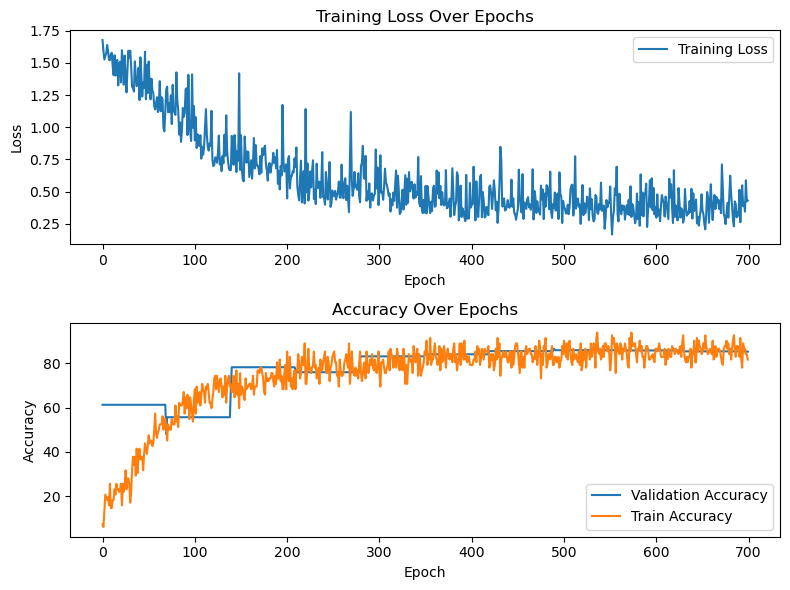

1 1 1 86.57407407407408
Epoch 1/70, Loss: 1.5919511097448844
Train Accuracy: 11.16%
Validation Accuracy: 2.08%
IO: 0.43727731704711914 Train: 16.0952250957489 Eval: 11.949978113174438
Epoch 2/70, Loss: 1.5973021233523335
Train Accuracy: 19.83%
IO: 0.1093757152557373 Train: 15.876798391342163 Eval: 0
Epoch 3/70, Loss: 1.4992151701891865
Train Accuracy: 23.87%
IO: 0.08858275413513184 Train: 15.767460584640503 Eval: 0
Epoch 4/70, Loss: 1.4418341583675809
Train Accuracy: 25.18%
IO: 0.1406269073486328 Train: 16.006058931350708 Eval: 0
Epoch 5/70, Loss: 1.2880005350819341
Train Accuracy: 39.55%
IO: 0.15625953674316406 Train: 16.678494930267334 Eval: 0
Epoch 6/70, Loss: 1.2847076190842524
Train Accuracy: 42.76%
IO: 0.14065122604370117 Train: 16.57060742378235 Eval: 0
Epoch 7/70, Loss: 1.2734297447734408
Train Accuracy: 47.39%
Validation Accuracy: 48.32%
IO: 0.3278532028198242 Train: 16.475799798965454 Eval: 12.177448034286499
Epoch 8/70, Loss: 1.2361141509479947
Train Accuracy: 53.92%
Validat

Epoch 64/70, Loss: 0.6622220653074758
Train Accuracy: 78.50%
Validation Accuracy: 85.36%
IO: 0.34369659423828125 Train: 16.764511823654175 Eval: 12.152291059494019
Epoch 65/70, Loss: 0.6414486489914082
Train Accuracy: 79.57%
IO: 0.07812213897705078 Train: 16.728753805160522 Eval: 0
Epoch 66/70, Loss: 0.7627419542383265
Train Accuracy: 74.94%
IO: 0.046895742416381836 Train: 16.564574003219604 Eval: 0
Epoch 67/70, Loss: 0.7231915758715736
Train Accuracy: 78.27%
IO: 0.10939168930053711 Train: 16.463090658187866 Eval: 0
Epoch 68/70, Loss: 0.63519937020761
Train Accuracy: 78.03%
IO: 0.14563632011413574 Train: 16.593950986862183 Eval: 0
Epoch 69/70, Loss: 0.6622535023424361
Train Accuracy: 77.43%
IO: 0.1562342643737793 Train: 16.682767152786255 Eval: 0
Epoch 70/70, Loss: 0.7061615111651244
Train Accuracy: 76.96%
Validation Accuracy: 85.71%
IO: 0.30141448974609375 Train: 16.71143937110901 Eval: 11.911083936691284


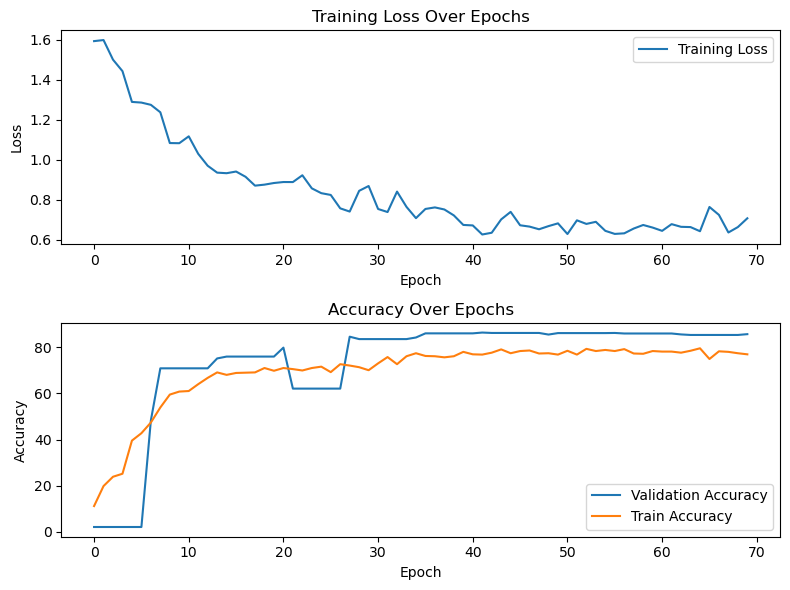

10 1 1 86.40046296296296
Epoch 1/14, Loss: 1.506860053448966
Train Accuracy: 24.22%
Validation Accuracy: 58.80%
IO: 0.583834171295166 Train: 82.80274152755737 Eval: 11.945561408996582
Epoch 2/14, Loss: 1.231373369693756
Train Accuracy: 52.76%
Validation Accuracy: 73.78%
IO: 0.7498772144317627 Train: 84.18213558197021 Eval: 12.608413219451904
Epoch 3/14, Loss: 0.9991524503989653
Train Accuracy: 65.59%
Validation Accuracy: 83.39%
IO: 0.8116676807403564 Train: 84.66248917579651 Eval: 12.576937437057495
Epoch 4/14, Loss: 0.932920656646743
Train Accuracy: 68.77%
Validation Accuracy: 81.42%
IO: 0.7500596046447754 Train: 81.81345701217651 Eval: 11.58191728591919
Epoch 5/14, Loss: 0.8631267768867088
Train Accuracy: 71.80%
Validation Accuracy: 82.99%
IO: 0.8281300067901611 Train: 79.2223744392395 Eval: 12.916866064071655
Epoch 6/14, Loss: 0.8419652709906752
Train Accuracy: 74.31%
Validation Accuracy: 85.76%
IO: 0.7027313709259033 Train: 85.2429141998291 Eval: 11.961808919906616
Epoch 7/14, Loss

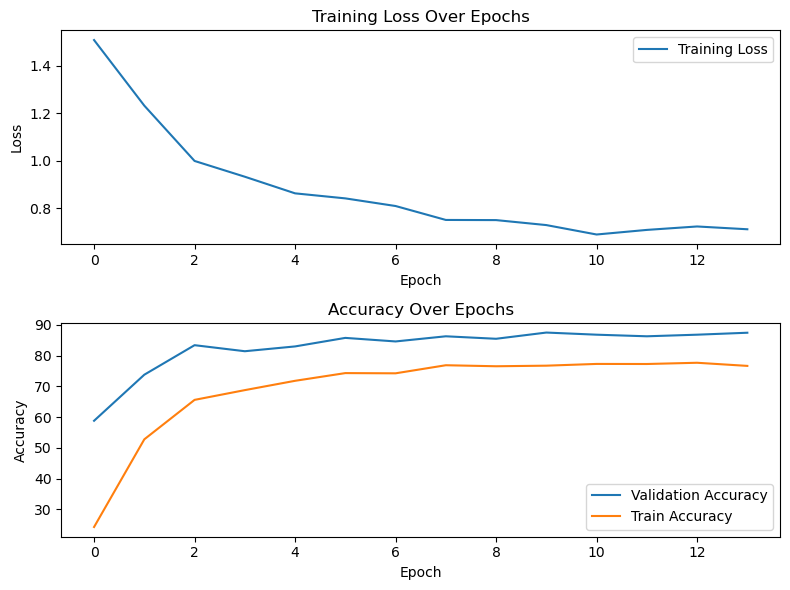

50 1 1 87.5
Epoch 1/7, Loss: 1.3860245511838885
Train Accuracy: 35.73%
Validation Accuracy: 73.90%
IO: 1.2239248752593994 Train: 169.65066075325012 Eval: 11.976645231246948
Epoch 2/7, Loss: 0.9812482946524115
Train Accuracy: 66.80%
Validation Accuracy: 83.22%
IO: 1.2310023307800293 Train: 167.5073103904724 Eval: 11.910805463790894
Epoch 3/7, Loss: 0.8483293794772842
Train Accuracy: 72.21%
Validation Accuracy: 83.62%
IO: 1.3717024326324463 Train: 168.3378701210022 Eval: 12.190665245056152
Epoch 4/7, Loss: 0.7784212091655442
Train Accuracy: 75.00%
Validation Accuracy: 85.19%
IO: 1.380464792251587 Train: 167.56229066848755 Eval: 12.171654224395752
Epoch 5/7, Loss: 0.7431387107706431
Train Accuracy: 76.15%
Validation Accuracy: 86.00%
IO: 1.2241547107696533 Train: 166.87828874588013 Eval: 11.811449766159058
Epoch 6/7, Loss: 0.7107887124699174
Train Accuracy: 77.08%
Validation Accuracy: 86.34%
IO: 1.3592772483825684 Train: 167.6507248878479 Eval: 12.139512300491333
Epoch 7/7, Loss: 0.6965827

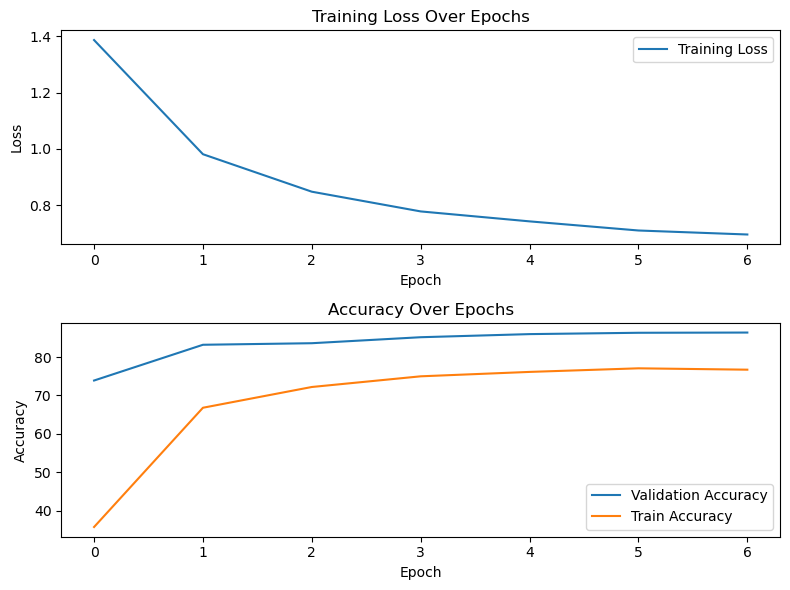

100 1 1 86.40046296296296


In [5]:
proportions = [1, 10, 50, 100]
resize = 224
alpha1s = [1]
alpha2s = [1]
for proportion in proportions:
    for alpha1, alpha2 in zip(alpha1s, alpha2s):
        mask_model_load_path = "CustomLoss_UNet_WBC" + str(proportion) +"_model.pth"
        classifier_model_load_path = ""
        classifier_model_save_path = "ResNet34_WBC" + str(proportion) +"_model.pth"
        train_dataloader, val_dataloader, train_label_counts, val_label_counts, device = init(proportion, resize)
        val_acc = train(train_dataloader, val_dataloader, train_label_counts, val_label_counts, classifier_model_load_path, 
              classifier_model_save_path, mask_model_load_path, device, alpha1, alpha2)
        print(proportion, alpha1, alpha2, val_acc)

D:\Anaconda\envs\cs5562\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\Anaconda\envs\cs5562\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/7, Loss: 1.569425106895241
Train Accuracy: 74.45%
Validation Accuracy: 93.52%
IO: 0.4280107021331787 Train: 87.56366539001465 Eval: 9.743269920349121
Epoch 2/7, Loss: 0.7427644293021524
Train Accuracy: 87.95%
Validation Accuracy: 94.50%
IO: 0.23417973518371582 Train: 76.3939847946167 Eval: 9.749335050582886
Epoch 3/7, Loss: 0.6211472759023309
Train Accuracy: 89.76%
Validation Accuracy: 96.35%
IO: 0.35132622718811035 Train: 80.76678133010864 Eval: 9.777282953262329
Epoch 4/7, Loss: 0.5391857847289154
Train Accuracy: 90.88%
Validation Accuracy: 96.93%
IO: 0.2965567111968994 Train: 80.97129368782043 Eval: 9.741404056549072
Epoch 5/7, Loss: 0.5037236290165421
Train Accuracy: 91.43%
Validation Accuracy: 97.22%
IO: 0.33095741271972656 Train: 82.16969895362854 Eval: 10.050313234329224
Epoch 6/7, Loss: 0.4962484128632103
Train Accuracy: 91.54%
Validation Accuracy: 96.82%
IO: 0.29917240142822266 Train: 81.5323646068573 Eval: 9.911845445632935
Epoch 7/7, Loss: 0.4785314039750533
Train Ac

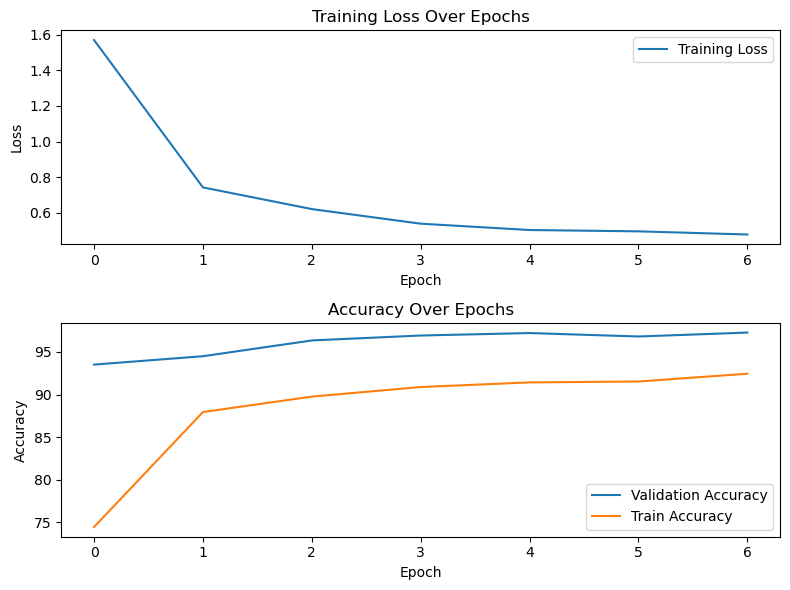

97.2800925925926

In [6]:
proportion = 100
resize = 224
alpha1 = -1
alpha2 = 1
mask_model_load_path = "CustomLoss_UNet_WBC" + str(proportion) +"_model.pth"
classifier_model_load_path = ""
classifier_model_save_path = "ResNet34_WBC" + str(proportion) +"_model.pth"
train_dataloader, val_dataloader, train_label_counts, val_label_counts, device = init(proportion, resize)
train(train_dataloader, val_dataloader, train_label_counts, val_label_counts, classifier_model_load_path, 
      classifier_model_save_path, mask_model_load_path, device, alpha1, alpha2)

In [7]:
print(np.array([0, 10.32, 4.61, 8.42, 2.36]).std())

3.795251770304574
